In [99]:
%reload_ext autoreload
%autoreload 2

In [100]:
from pathlib import Path
import tempfile

import numpy as np
from umap import UMAP

In [101]:
import roicat

In [102]:
# Import vrAnalysis related code
from vrAnalysis import database

In [103]:
# Create link to vrDatabase containing all data and get session paths for target mouse
mouseName = "ATL027"
planeName = "plane0"
vrdb = database.vrDatabase('vrSessions')
ises = vrdb.iterSessions(imaging=True, mouseName=mouseName, dontTrack=False)
pathList = []
for ses in ises:
    pathList.append(ses.sessionPath())
for idx, pl in enumerate(pathList): print(idx, pl)

0 C:\Users\andrew\Documents\localData\ATL027\2023-07-19\701
1 C:\Users\andrew\Documents\localData\ATL027\2023-07-20\701
2 C:\Users\andrew\Documents\localData\ATL027\2023-07-21\701
3 C:\Users\andrew\Documents\localData\ATL027\2023-07-24\701
4 C:\Users\andrew\Documents\localData\ATL027\2023-07-25\701
5 C:\Users\andrew\Documents\localData\ATL027\2023-07-26\701
6 C:\Users\andrew\Documents\localData\ATL027\2023-07-27\701
7 C:\Users\andrew\Documents\localData\ATL027\2023-07-28\701
8 C:\Users\andrew\Documents\localData\ATL027\2023-08-01\701
9 C:\Users\andrew\Documents\localData\ATL027\2023-08-02\701
10 C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702
11 C:\Users\andrew\Documents\localData\ATL027\2023-08-07\701
12 C:\Users\andrew\Documents\localData\ATL027\2023-08-08\701
13 C:\Users\andrew\Documents\localData\ATL027\2023-08-09\701


In [104]:
dir_allOuterFolders = pathList[10] #r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/stat_and_ops'

pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'

paths_allStat = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToStat,
    depth=6,
)[:]
paths_allOps  = np.array([Path(path).resolve().parent / pathSuffixToOps for path in paths_allStat])[:]

print(f'paths to all stat files:');
[print(path) for path in paths_allStat];
print('');
print(f'paths to all ops files:');
[print(path) for path in paths_allOps];

paths to all stat files:
C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane0\stat.npy
C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane1\stat.npy
C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane2\stat.npy
C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane3\stat.npy
C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane4\stat.npy

paths to all ops files:
C:\Users\Andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane0\ops.npy
C:\Users\Andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane1\ops.npy
C:\Users\Andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane2\ops.npy
C:\Users\Andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane3\ops.npy
C:\Users\Andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane4\ops.npy


In [105]:
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=1.6,  
    new_or_old_suite2p='new',
    type_meanImg='meanImgE',
    verbose=True,
)

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

c:\users\andrew\documents\github\roicat\roicat\util.py:416: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] The system cannot find the file specified
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 5 FOV images.
Setting FOV_images...
Completed: Set FOV_images for 5 sessions successfully.
Importing spatial footprints from stat files.


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Imported 5 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 5 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Starting: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


In [106]:
DEVICE = roicat.helpers.set_device(use_GPU=True, verbose=True)
dir_temp = tempfile.gettempdir()

roinet = roicat.ROInet.ROInet_embedder(
    device=DEVICE,  ## Which torch device to use ('cpu', 'cuda', etc.)
    dir_networkFiles=dir_temp,  ## Directory to download the pretrained network to
    download_method='check_local_first',  ## Check to see if a model has already been downloaded to the location (will skip if hash matches)
    download_url='https://osf.io/c8m3b/download',  ## URL of the model
    download_hash='357a8d9b630ec79f3e015d0056a4c2d5',  ## Hash of the model file
    forward_pass_version='head',  ## How the data is passed through the network
    verbose=True,  ## Whether to print updates
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,  ## Input images of ROIs
    um_per_pixel=data.um_per_pixel,  ## Resolution of FOV
    pref_plot=False,  ## Whether or not to plot the ROI sizes
);
images = roinet.ROI_images_rs

Using device: cuda:0


c:\users\andrew\documents\github\roicat\roicat\util.py:416: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] The system cannot find the file specified
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


File already exists locally: C:\Users\Andrew\AppData\Local\Temp\ROInet.zip
Hash of local file matches provided hash_hex.
Extracting C:\Users\Andrew\AppData\Local\Temp\ROInet.zip to C:\Users\Andrew\AppData\Local\Temp.
Completed zip extraction.
Imported model from C:\Users\Andrew\AppData\Local\Temp\ROInet_classification_20220902\model.py
Loaded params_model from C:\Users\Andrew\AppData\Local\Temp\ROInet_classification_20220902\params.json


C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Andrew\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from C:\Users\Andrew\AppData\Local\Temp\ROInet_classification_20220902\ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Starting Image Resizer
Creating dataloader
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader



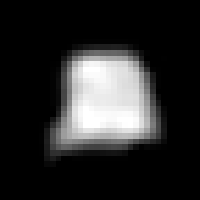

In [107]:
roicat.visualization.display_toggle_image_stack(images[:1000], image_size=(200,200))

In [108]:
roinet.generate_latents();

starting: running data through network


  0%|          | 0/2150 [00:06<?, ?it/s]

completed: running data through network


In [109]:
model_umap = UMAP(
    n_neighbors=25,
    n_components=2,
    n_epochs=400,
    verbose=True,
    densmap=False,
)
emb = model_umap.fit_transform(roinet.latents)

UMAP(n_epochs=400, n_neighbors=25, verbose=True)
Fri Dec 13 16:46:05 2024 Construct fuzzy simplicial set
Fri Dec 13 16:46:05 2024 Finding Nearest Neighbors
Fri Dec 13 16:46:05 2024 Building RP forest with 12 trees
Fri Dec 13 16:46:06 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Dec 13 16:46:06 2024 Finished Nearest Neighbor Search
Fri Dec 13 16:46:06 2024 Construct embedding


Epochs completed:   0%|            0/400 [00:00]

	completed  0  /  400 epochs
	completed  40  /  400 epochs
	completed  80  /  400 epochs
	completed  120  /  400 epochs
	completed  160  /  400 epochs
	completed  200  /  400 epochs
	completed  240  /  400 epochs
	completed  280  /  400 epochs
	completed  320  /  400 epochs
	completed  360  /  400 epochs
Fri Dec 13 16:46:08 2024 Finished embedding


In [110]:
idx_images_overlay = roicat.visualization.get_spread_out_points(
    emb,
    n_ims=min(emb.shape[0], 1500),  ## Select number of overlayed images here
    dist_im_to_point=0.8,
#     border_frac=0.05,
)

images_overlay = images[idx_images_overlay]

In [111]:
images = np.concatenate(data.ROI_images, axis=0)

In [112]:
from integrated import IntegratedLabeler

In [97]:
# Just tried to make the selected point blue and the overlay toggleable
images = np.concatenate(data.ROI_images, axis=0)
idx_images_overlay = roicat.visualization.get_spread_out_points(
    emb,
    n_ims=min(emb.shape[0], 1500),  ## Select number of overlayed images here
    dist_im_to_point=0.8,
)

with IntegratedLabeler(
    images,
    embeddings=emb,
    idx_images_overlay=idx_images_overlay,
    size_images_overlay=0.25,
    frac_overlap_allowed=0.25,
    crop_images_overlay=0.25,
    alpha_points=1.0,
    size_points=3.0,
) as labeler:
    labeler.run()

Image 3: c
Image 4: c
Image 5: c
Image 310: w
Image 596: w
Image 604: w
Image 654: w
Image 672: w
Image 796: w


In [98]:
labeler.labels_

{3: 'c',
 4: 'c',
 5: 'c',
 310: 'w',
 596: 'w',
 604: 'w',
 654: 'w',
 672: 'w',
 796: 'w'}